### Continuous contribution analysis
We want to know whether the number of upvotes has impact on the authors' continuous contribution. The analysis consists of three parts:
1. How many authors keep contributing?
2. Among those who contribute continuously, how soon do they contribute?
3. How much do they contribute?

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')
df = df.drop(columns=['down_votes', 'category'])
df.date_created = pd.to_datetime(df.date_created)

In [3]:
# sort by time
df.sort_values(by=['time_created'], inplace=True)
# nth content by each author
df['nth_content'] = df.groupby(['author']).cumcount()+1

In [4]:
df.head(5)

,time_created,date_created,up_votes,title,over_18,author,nth_content
0,1201232046,2008-01-25,3,Scores killed in Pakistan clashes,False,polar,1
1,1201232075,2008-01-25,2,Japan resumes refuelling mission,False,polar,2
2,1201232523,2008-01-25,3,US presses Egypt on Gaza border,False,polar,3
3,1201233290,2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420,1
4,1201274720,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans,1


In [5]:
df_1st = df[df.nth_content == 1]

In [6]:
def up_votes_category(up_votes):
    if up_votes>20:
        return 'high'
    return 'low'

df_1st['up_votes_category'] = df_1st.up_votes.apply(up_votes_category)

C:\Users\Xiaobin\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
df_1st.up_votes_category.value_counts()

low     67846
high    17992
Name: up_votes_category, dtype: int64

In [8]:
df_1st.describe(include='object')

,title,author,up_votes_category
count,85838,85838,85838
unique,85501,85838,2
top,New SARS-like virus is a threat to the entire...,posting_from_work,low
freq,4,1,67846


No author with the same name. Good for later analysis.

In [11]:
%%time
df_1st = df_1st.sample(10000, random_state=2019) # use only a subset because of time costs

# time interval for the nth post after the first one, excluding the posts of the same day with the first
def author_nth_time_diff(author, nth=2):
    df_author = df[df.author == author]
    time_1st = list(df_author.date_created)[0]
    if len(list(df_author[df_author.date_created > time_1st].date_created)) > nth-2:
        return (list(df_author[df_author.date_created > time_1st].date_created)[nth-2]-time_1st).days
    return -1
    
df_1st['2nd_time_diff'] = df_1st.author.apply(lambda x: author_nth_time_diff(x))
df_1st['5th_time_diff'] = df_1st.author.apply(lambda x: author_nth_time_diff(x, nth=5))
df_1st['10th_time_diff'] = df_1st.author.apply(lambda x: author_nth_time_diff(x, nth=10))
df_1st['20th_time_diff'] = df_1st.author.apply(lambda x: author_nth_time_diff(x, nth=20))
df_1st['30th_time_diff'] = df_1st.author.apply(lambda x: author_nth_time_diff(x, nth=30))

Wall time: 17min 15s


In [12]:
%%time
from datetime import datetime, timedelta

def author_number_of_posts(author, days_diff=30):
    df_author = df[df.author == author]
    time_1st = list(df_author.date_created)[0]
    time_days_later = time_1st + timedelta(days=days_diff)
    return df_author[df_author.date_created <= time_days_later].shape[0]

df_1st['no_of_posts_in_month'] = df_1st.author.apply(lambda x: author_number_of_posts(x))
df_1st['no_of_posts_in_quarter'] = df_1st.author.apply(lambda x: author_number_of_posts(x, 90))
df_1st['no_of_posts_in_year'] = df_1st.author.apply(lambda x: author_number_of_posts(x, 365))

Wall time: 10min 29s


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
import numpy as np

#### Continuous contribution rate
After their initial post, what's the rate of authors who keep contributing.

In [39]:
all_cnt = np.array(df_1st[['2nd_time_diff', 'up_votes_category']].groupby('up_votes_category').count()).reshape(2,-1)
all_cnt

array([[2092],
       [7908]], dtype=int64)

In [63]:
each_cnt = np.array(df_1st[(df_1st['2nd_time_diff']>0)][['2nd_time_diff', 'up_votes_category']].groupby('up_votes_category').count()).reshape(2,-1)
tmp = np.array(df_1st[(df_1st['5th_time_diff']>0)][['5th_time_diff', 'up_votes_category']].groupby('up_votes_category').count()).reshape(2,-1)
each_cnt = np.hstack([each_cnt, tmp])
tmp = np.array(df_1st[(df_1st['10th_time_diff']>0)][['10th_time_diff', 'up_votes_category']].groupby('up_votes_category').count()).reshape(2,-1)
each_cnt = np.hstack([each_cnt, tmp])
tmp = np.array(df_1st[(df_1st['20th_time_diff']>0)][['20th_time_diff', 'up_votes_category']].groupby('up_votes_category').count()).reshape(2,-1)
each_cnt = np.hstack([each_cnt, tmp])
tmp = np.array(df_1st[(df_1st['30th_time_diff']>0)][['30th_time_diff', 'up_votes_category']].groupby('up_votes_category').count()).reshape(2,-1)
each_cnt = np.hstack([each_cnt, tmp])
each_cnt

array([[ 802,  309,  172,   84,   63],
       [2746, 1047,  551,  286,  201]], dtype=int64)

In [33]:
df_1st[(df_1st['2nd_time_diff']>0)][['2nd_time_diff', 'up_votes_category']].groupby('up_votes_category').count()

,2nd_time_diff
up_votes_category,
high,802
low,2746


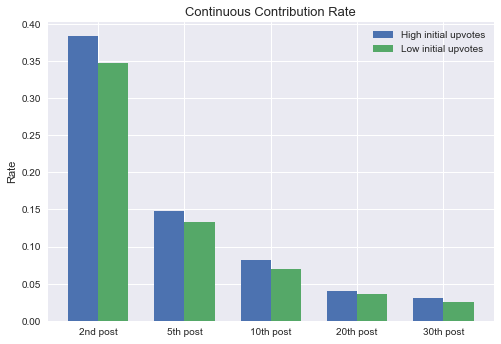

In [74]:
continuous_contribution_rate = each_cnt/all_cnt
high = continuous_contribution_rate[0].reshape(5, )
low = continuous_contribution_rate[1].reshape(5, )

N = high.shape[0]

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, high, width, label='High initial upvotes')
plt.bar(ind + width, low, width,
    label='Low initial upvotes')

plt.ylabel('Rate')
plt.title('Continuous Contribution Rate', fontsize=13)

plt.xticks(ind + width / 2, ('2nd post', '5th post', '10th post', '20th post', '30th post'))
plt.legend(loc='best')
plt.show()

#### Time interval for next nth posts

In [78]:
df_1st[(df_1st['2nd_time_diff']>0)][['2nd_time_diff', 'up_votes_category']].groupby('up_votes_category').mean()

,2nd_time_diff
up_votes_category,
high,114.714464
low,105.707210


In [79]:
each_mean = np.array(df_1st[(df_1st['2nd_time_diff']>0)][['2nd_time_diff', 'up_votes_category']].groupby('up_votes_category').mean()).reshape(2,-1)
tmp = np.array(df_1st[(df_1st['5th_time_diff']>0)][['5th_time_diff', 'up_votes_category']].groupby('up_votes_category').mean()).reshape(2,-1)
each_mean = np.hstack([each_mean, tmp])
tmp = np.array(df_1st[(df_1st['10th_time_diff']>0)][['10th_time_diff', 'up_votes_category']].groupby('up_votes_category').mean()).reshape(2,-1)
each_mean = np.hstack([each_mean, tmp])
tmp = np.array(df_1st[(df_1st['20th_time_diff']>0)][['20th_time_diff', 'up_votes_category']].groupby('up_votes_category').mean()).reshape(2,-1)
each_mean = np.hstack([each_mean, tmp])
tmp = np.array(df_1st[(df_1st['30th_time_diff']>0)][['30th_time_diff', 'up_votes_category']].groupby('up_votes_category').mean()).reshape(2,-1)
each_mean = np.hstack([each_mean, tmp])
each_mean

array([[114.71446384, 194.97734628, 258.13953488, 280.82142857,
        328.77777778],
       [105.70721049, 186.47373448, 232.35027223, 275.83916084,
        311.36318408]])

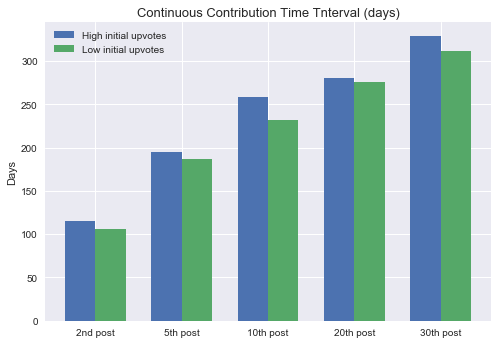

In [83]:
continuous_contribution_time_interval = each_mean
high = continuous_contribution_time_interval[0].reshape(5, )
low = continuous_contribution_time_interval[1].reshape(5, )

N = high.shape[0]

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, high, width, label='High initial upvotes')
plt.bar(ind + width, low, width,
    label='Low initial upvotes')

plt.ylabel('Days')
plt.title('Continuous Contribution Time Tnterval (days)', fontsize=13)

plt.xticks(ind + width / 2, ('2nd post', '5th post', '10th post', '20th post', '30th post'))
plt.legend(loc='best')
plt.show()

#### Quantity of posts
- How many posts do they contribute after a given time interval since their initial post?

In [86]:
df_1st[(df_1st['no_of_posts_in_month']>1)][['no_of_posts_in_month', 'up_votes_category']].groupby('up_votes_category').mean()

,no_of_posts_in_month
up_votes_category,
high,5.690632
low,5.624204


In [87]:
df_1st[(df_1st['no_of_posts_in_quarter']>1)][['no_of_posts_in_quarter', 'up_votes_category']].groupby('up_votes_category').mean()

no_of_posts = np.array(df_1st[(df_1st['no_of_posts_in_month']>1)][['no_of_posts_in_month', 'up_votes_category']].groupby('up_votes_category').mean()).reshape(2,-1)
tmp = np.array(df_1st[(df_1st['no_of_posts_in_quarter']>1)][['no_of_posts_in_quarter', 'up_votes_category']].groupby('up_votes_category').mean()).reshape(2,-1)
no_of_posts = np.hstack([no_of_posts, tmp])
tmp = np.array(df_1st[(df_1st['no_of_posts_in_year']>1)][['no_of_posts_in_year', 'up_votes_category']].groupby('up_votes_category').mean()).reshape(2,-1)
no_of_posts = np.hstack([no_of_posts, tmp])
no_of_posts

array([[ 5.69063181,  7.42141623, 11.30687831],
       [ 5.62420382,  7.20689655,  9.91307606]])

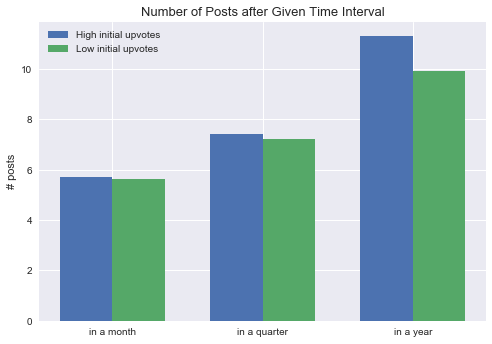

In [90]:
high = no_of_posts[0].reshape(3, )
low = no_of_posts[1].reshape(3, )

N = high.shape[0]

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, high, width, label='High initial upvotes')
plt.bar(ind + width, low, width,
    label='Low initial upvotes')

plt.ylabel('# posts')
plt.title('Number of Posts after Given Time Interval', fontsize=13)

plt.xticks(ind + width / 2, ('in a month', 'in a quarter', 'in a year'))
plt.legend(loc='best')
plt.show()

- No difference in short term.
- Authors with high initial upvotes tend to contribute more in long run, indicating incentive effect of the number of upvotes from their first post.

##### Indications
- Since a high initial upvotes will motivate an author to contribute more to the platform, the platform need to came up with better recomendation system to let the content being watched by more people.